# HEX UCR Dataset: 179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800

**Dataset Link:** https://www.cs.ucr.edu/~eamonn/time_series_data_2018/UCR_TimeSeriesAnomalyDatasets2021.zip

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Anomaly Detection (LSTM-AD) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-4pbvedtnnlphw).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/lstm-ad-algo-v1-7"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

### 2. Data preparation

Load the data.

In [3]:
dataset_name = "179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800"
cutoff = 23000  # train-test cutoff
start = 52600   # start of anomalous time interval
end = 52800     # end of anomalous time interval
k = 2           # number of anomalies to extract

In [4]:
dataset = pd.DataFrame(data=np.genfromtxt(f"{dataset_name}.txt"))

In [5]:
dataset.shape

(55000, 1)

In [6]:
dataset.head()

,0
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0


In [7]:
dataset.tail()

,0
54995,27.0
54996,24.0
54997,22.0
54998,21.0
54999,19.0


Visualize the data.

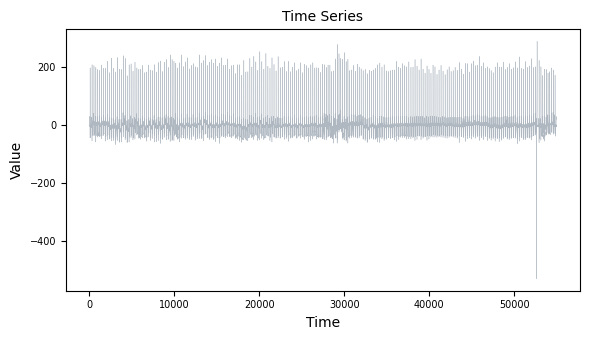

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(6, 3.5))
ax.set_title("Time Series", size=10)
ax.plot(dataset, color="#AFB8C1", lw=0.3)
ax.set(xlabel="Time", ylabel="Value")
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Split the data.

In [9]:
training_dataset = dataset.iloc[:cutoff]

In [10]:
training_dataset.shape

(23000, 1)

In [11]:
test_dataset = dataset.iloc[cutoff:]

In [12]:
test_dataset.shape

(32000, 1)

Upload the data to S3.

In [13]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key=f"{dataset_name}_train.csv"
)

In [14]:
training_data

's3://sagemaker-eu-west-1-661670223746/179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800_train.csv'

In [15]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key=f"{dataset_name}_test.csv"
)

In [16]:
test_data

's3://sagemaker-eu-west-1-661670223746/179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800_test.csv'

### 3. Training

Fit the model to the training set.

In [17]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "context-length": 200,
        "prediction-length": 100,
        "sequence-stride": 100,
        "hidden-size": 256,
        "num-layers": 2,
        "dropout": 0.8,
        "lr": 0.001,
        "batch-size": 16,
        "epochs": 500,
    }
)

estimator.fit({"training": training_data})

NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.
INFO:sagemaker:Creating training-job with name: lstm-ad-algo-v1-7-2023-09-16-18-51-59-896


2023-09-16 18:52:00 Starting - Starting the training job...
2023-09-16 18:52:15 Starting - Preparing the instances for training......
2023-09-16 18:53:30 Downloading - Downloading input data
2023-09-16 18:53:30 Training - Downloading the training image.....................
2023-09-16 18:56:41 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-16 18:57:11,973 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-16 18:57:11,974 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-16 18:57:11,975 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-16 18:57:11,984 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-16 18:57:11,986 sagemaker_pytorch_container.training INFO     Invokin

### 4. Inference

Generate the test set predictions.

In [18]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: lstm-ad-algo-v1-7-2023-09-16-19-16-40-988


.........

INFO:sagemaker:Creating model with name: lstm-ad-algo-v1-7-2023-09-16-19-16-40-9-2023-09-16-19-17-26-459


INFO:sagemaker:Creating transform job with name: lstm-ad-algo-v1-7-2023-09-16-19-17-27-199


2023-09-16T19:24:50,667 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2023-09-16T19:24:50,670 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-09-16T19:24:50,736 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-09-16T19:24:50,846 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.2
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7840 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Infer

Load the test set predictions from S3.

In [19]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/{dataset_name}_test.csv.out"
)

In [20]:
predictions = pd.DataFrame([x.split(",") for x in predictions.split("\n")[:-1]]).replace("", np.nan).astype(float)

In [21]:
predictions.shape

(32000, 2)

In [22]:
predictions.head()

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [23]:
predictions.tail()

,0,1
31995,1.250345,-6.506207
31996,1.344912,-6.583544
31997,1.435532,-5.249293
31998,1.479056,-4.343917
31999,1.528201,-3.776419


Extract the anomalous time steps.

In [24]:
anomalies = predictions.iloc[:, 0].sort_values().iloc[:k].index.to_series()

In [25]:
anomalies.values

array([29639, 29640])

Check if the anomalous time steps are within the anomalous time interval.

In [26]:
anomalies.between(start - cutoff, end - cutoff).values

array([ True,  True])

Visualize the predictions and the normality scores.

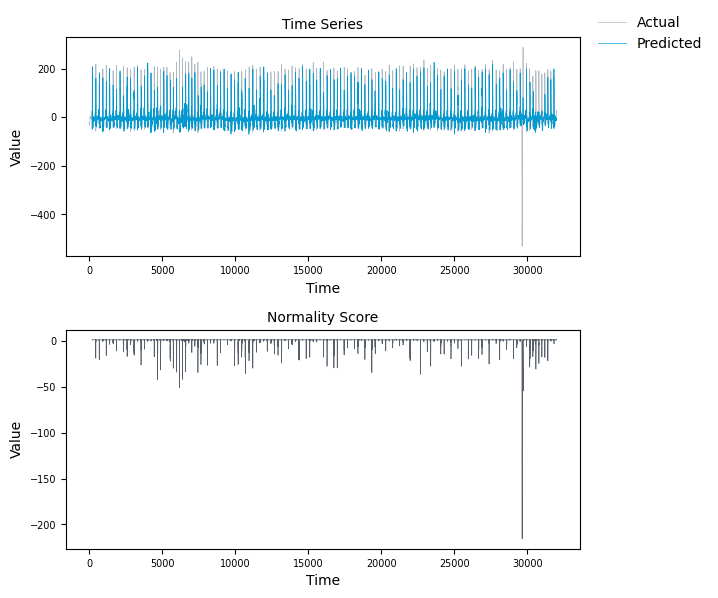

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 6))

axs[0].set_title("Time Series", size=10)
axs[0].plot(test_dataset.values, color="#AFB8C1", lw=0.5, label="Actual")
axs[0].plot(predictions.iloc[:, 1], color="#009ad3", lw=0.5, label="Predicted")
axs[0].set(xlabel="Time", ylabel="Value")
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].tick_params(axis="both", which="major", labelsize=7)
axs[0].tick_params(axis="both", which="minor", labelsize=7)

axs[1].set_title("Normality Score", size=10)
axs[1].plot(predictions.iloc[:, 0], color="#57606a", lw=0.5)
axs[1].set(xlabel="Time", ylabel="Value")
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].tick_params(axis="both", which="major", labelsize=7)
axs[1].tick_params(axis="both", which="minor", labelsize=7)

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.2, 1, 0, 0), frameon=False)
fig.show()